Distance-based:
Energy-based:
Trajectory cost-based:


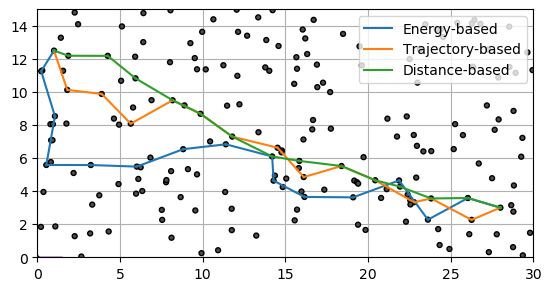

In [1]:
# Get report data
import numpy as np
import environment, path_planner, visualizer, acrobot, trajectory_optimization, analysis
import importlib
from collections import namedtuple 
from pydrake.all import (MultibodyPlant, Parser, RigidTransform, PiecewisePolynomial)
importlib.reload(environment)
importlib.reload(path_planner)
importlib.reload(visualizer)
importlib.reload(acrobot)
importlib.reload(trajectory_optimization)
importlib.reload(analysis)
from acrobot import Acrobot
from visualizer import AcrobotVisualizer
from environment import Environment
from path_planner import AStarPathPlanner, EnergyPathPlanner, TrajectoryMatchPathPlanner
from trajectory_optimization import DirectCollocationParameters, DirectCollocationTrajectoryGenerator
from analysis import get_total_effort

plant = MultibodyPlant(time_step=0)
parser = Parser(plant)
parser.AddModels("acrobot.urdf")
plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()

env = Environment()
env.generate_random_uniform((0, 30, 0, 15), (1, 12.5), (28, 3),200)
bot = Acrobot(plant)
vis = AcrobotVisualizer(bot,env)
trajectory_inputs = np.genfromtxt("collocation_sim_results.csv", delimiter=',', skip_header=1)
print("Distance-based:")
dist_planner = AStarPathPlanner(env)
dist_path = dist_planner.calculate_path()
print("Energy-based:")
energy_planner = EnergyPathPlanner(env)
energy_path = energy_planner.calculate_path()
print("Trajectory cost-based:")
traj_match_planner = TrajectoryMatchPathPlanner(env, trajectory_inputs)
traj_path = traj_match_planner.calculate_path()
paths = {
    "Energy-based": energy_planner.calculate_path(),
    "Trajectory-based": traj_match_planner.calculate_path(),
    "Distance-based": dist_planner.calculate_path()
}
file_path = "./env_plot/A_star_test.png"
# planner.plot(env, paths, file_path)


vis.draw_path(paths)
vis.ax.legend(loc="upper right")



In [ ]:
# Run trajectory optimization on the Trajectory-based plan
SimulationResult = namedtuple('SimulationResult',['current_hold', 'total_segment_input', 'path_info', 'start_hold_error', 'goal_hold_error'])

simulation = SimulationResult(current_hold=np.zeros(len(paths["Trajectory-based"])), 
                              total_segment_input=np.zeros(len(paths["Trajectory-based"])), 
                              path_info=np.zeros((len(paths["Trajectory-based"]),
                                                 np.size(traj_match_planner.trajectory_inputs,1))),
                              start_hold_error=np.zeros(len(paths["Trajectory-based"])), 
                              goal_hold_error=np.zeros(len(paths["Trajectory-based"]))
                              )

for i, hold_index in enumerate(paths["Trajectory-based"]):
    simulation.current_hold[i] = hold_index
    
    #find path info
    prev_hold = None
    next_hold = None
    if i != 0:
        prev_hold = paths["Trajectory-based"][i-1]
    if i != len(paths["Trajectory-based"])-1:
        next_hold = paths["Trajectory-based"][i+1]
        simulation.path_info[i] = traj_match_planner.chosen_trajectories[(prev_hold, hold_index, next_hold)]
        
        if i != 0:
            diff = env.get_relative_position(hold_index,prev_hold) - simulation.path_info[i,0:2]
        else:
            diff = np.array([0,-traj_match_planner.range]) - simulation.path_info[i,0:2]
        goal_diff = env.get_relative_position(hold_index,next_hold) - simulation.path_info[i,2:4]
        simulation.start_hold_error[i] = np.sqrt(np.dot(diff,diff))
        simulation.goal_hold_error[i] = np.sqrt(np.dot(goal_diff,goal_diff))
    

effort = 0
results = []
i = 0
start_state = np.zeros(4)

for i, curr_hold in enumerate(simulation.current_hold[0:-1]):
    print("Evaluating step {}/{}...".format(i, len(simulation.current_hold[0:-2])))
    # Set up DirectCollocation
    opts = DirectCollocationParameters()
    traj_opt = DirectCollocationTrajectoryGenerator(bot, opts)
    traj_opt.params.time_cost = simulation.path_info[i,4]
    traj_opt.params.R = simulation.path_info[i,5]

    sol = traj_opt.generate_trajectory(start_state, env.holds[int(simulation.current_hold[i+1])].position)
    if sol.is_success():
        # x_traj = traj_opt.collocation_prog.ReconstructStateTrajectory(sol)
        u_traj = traj_opt.collocation_prog.ReconstructInputTrajectory(sol)

        # trajectories = {1:x_traj, 2:u_traj}
        effort = get_total_effort(u_traj, 1)
    else:
        effort = -1        
    # results.append(np.array([time_cost, input_cost, effort]))
    simulation.total_segment_input[i] = effort
    
    # Set the start state of the bot for the next iteration 
    start_pos = env.get_relative_position(simulation.current_hold[i+1], curr_hold)
    start_state = np.hstack((bot.get_joint_angles(start_pos,start_pos[0] > 0), np.zeros(2)))

print("Trajectory-based path planning:")
print("Total planned effort: {}".format(np.sum(simulation.path_info[:,7])))
print("Total calculated effort: {}".format(np.sum(simulation.total_segment_input)))

## Evaluate performance

Evaluating step 0/13...
Evaluating step 1/13...
Evaluating step 2/13...
Evaluating step 3/13...
Evaluating step 4/13...
Evaluating step 5/13...
Evaluating step 6/13...
Evaluating step 7/13...
Evaluating step 8/13...
Evaluating step 9/13...
Evaluating step 10/13...
Evaluating step 11/13...
Evaluating step 12/13...
Evaluating step 13/13...
Trajectory-based path planning:
Total planned effort: 1.668045561327636
Total calculated effort: 11.5677748647689


In [ ]:
# Display the stats for each step of the trajectory-based plan, after simulation
for i, curr_hold in enumerate(simulation.current_hold):
    print("{}.\tHold {}:\tplan:{:.4f}\tcalc: {:.4f}\tdiff: {:.4f}\tstarterr: {:.4f}\tgoalerr: {:.4f}".format(i, curr_hold, 
                                                         simulation.path_info[i,7],
                                                         simulation.total_segment_input[i],
                                                         simulation.total_segment_input[i]-simulation.path_info[i,7],
                                                         simulation.start_hold_error[i],
                                                         simulation.goal_hold_error[i]))
    

0.	Hold 0.0:	plan:0.3590	calc: 2.8768	diff: 2.5178	starterr: 0.0000	goalerr: 0.4926
1.	Hold 140.0:	plan:1.0319	calc: 1.7882	diff: 0.7563	starterr: 0.4926	goalerr: 0.2245
2.	Hold 31.0:	plan:0.0382	calc: 0.6121	diff: 0.5739	starterr: 0.2245	goalerr: 0.5154
3.	Hold 91.0:	plan:0.0066	calc: 1.5382	diff: 1.5316	starterr: 0.5154	goalerr: 0.3631
4.	Hold 37.0:	plan:0.0982	calc: 0.0212	diff: -0.0770	starterr: 0.3631	goalerr: 0.4847
5.	Hold 66.0:	plan:0.0107	calc: 4.5234	diff: 4.5127	starterr: 0.4847	goalerr: 0.3033
6.	Hold 58.0:	plan:0.0102	calc: 0.0588	diff: 0.0486	starterr: 0.3033	goalerr: 0.2785
7.	Hold 151.0:	plan:0.0064	calc: 0.0156	diff: 0.0092	starterr: 0.2785	goalerr: 0.4787
8.	Hold 194.0:	plan:0.0075	calc: 0.0248	diff: 0.0173	starterr: 0.4787	goalerr: 0.3258
9.	Hold 68.0:	plan:0.0071	calc: 0.0423	diff: 0.0352	starterr: 0.3258	goalerr: 0.3980
10.	Hold 103.0:	plan:0.0140	calc: 0.0085	diff: -0.0055	starterr: 0.3980	goalerr: 0.4431
11.	Hold 87.0:	plan:0.0074	calc: 0.0053	diff: -0.0021	start